# Use a 2D convolutional neural net to identify the artist behind a painting

The title kind of says it all. This notebook is a 2D convolutional neural net (from scratch) to identify the artist behind a painting. There are over 50 artists with over 8000 paintings, some of them kind of similar in the technique, so this makes the training and identification sort of tricky. 

Having said that, I personally am a big fan of Ernst Ludwig Kirchner, so I was a little bit disappointed not to find him in the list of 'the best artworks of all time' (as you will see later). Here, just for completeness a nice painting of Kirchner (title: Nollendorfplatz): 

![](https://upload.wikimedia.org/wikipedia/commons/f/ff/Ernst_Ludwig_Kirchner_-_Nollendorfplatz.jpg)

In any case enjoy the notebook. Any ideas, suggestions or comments are of course more than welcome and appreciated. Have fun!

In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib import gridspec
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
# define a couple of constants
IMG_HEIGHT  = 300
IMG_WIDTH   = 300
BATCH_SIZE  = 32
EPOCHS      = 20
SEED        = 1234
strPath     = "../input/best-artworks-of-all-time/images/images/"

# Prepare data

Next part is to read the data for further usage. For this, predefined functions of Keras are used. I use 20% for validation. The image sizes are rather large since it increases accuracy later.

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  strPath,
  validation_split = 0.2,
  subset     = "training",
  seed       = SEED,
  image_size = (IMG_HEIGHT, IMG_WIDTH),
  batch_size = BATCH_SIZE)

Found 8774 files belonging to 51 classes.
Using 7020 files for training.


In [4]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  strPath,
  validation_split = 0.2,
  subset     = "validation",
  seed       = SEED,
  image_size = (IMG_HEIGHT, IMG_WIDTH),
  batch_size = BATCH_SIZE)


Found 8774 files belonging to 51 classes.
Using 1754 files for validation.


Get ( and print) the name of classes, i.e. the name of the artists.

In [5]:
# get the artists names
class_names = train_ds.class_names

# define for later
num_classes = len(class_names)

print(class_names)

['Albrecht_Dürer', 'Albrecht_Du╠êrer', 'Alfred_Sisley', 'Amedeo_Modigliani', 'Andrei_Rublev', 'Andy_Warhol', 'Camille_Pissarro', 'Caravaggio', 'Claude_Monet', 'Diego_Rivera', 'Diego_Velazquez', 'Edgar_Degas', 'Edouard_Manet', 'Edvard_Munch', 'El_Greco', 'Eugene_Delacroix', 'Francisco_Goya', 'Frida_Kahlo', 'Georges_Seurat', 'Giotto_di_Bondone', 'Gustav_Klimt', 'Gustave_Courbet', 'Henri_Matisse', 'Henri_Rousseau', 'Henri_de_Toulouse-Lautrec', 'Hieronymus_Bosch', 'Jackson_Pollock', 'Jan_van_Eyck', 'Joan_Miro', 'Kazimir_Malevich', 'Leonardo_da_Vinci', 'Marc_Chagall', 'Michelangelo', 'Mikhail_Vrubel', 'Pablo_Picasso', 'Paul_Cezanne', 'Paul_Gauguin', 'Paul_Klee', 'Peter_Paul_Rubens', 'Pierre-Auguste_Renoir', 'Piet_Mondrian', 'Pieter_Bruegel', 'Raphael', 'Rembrandt', 'Rene_Magritte', 'Salvador_Dali', 'Sandro_Botticelli', 'Titian', 'Vasiliy_Kandinskiy', 'Vincent_van_Gogh', 'William_Turner']


# Visualise some of the paintings

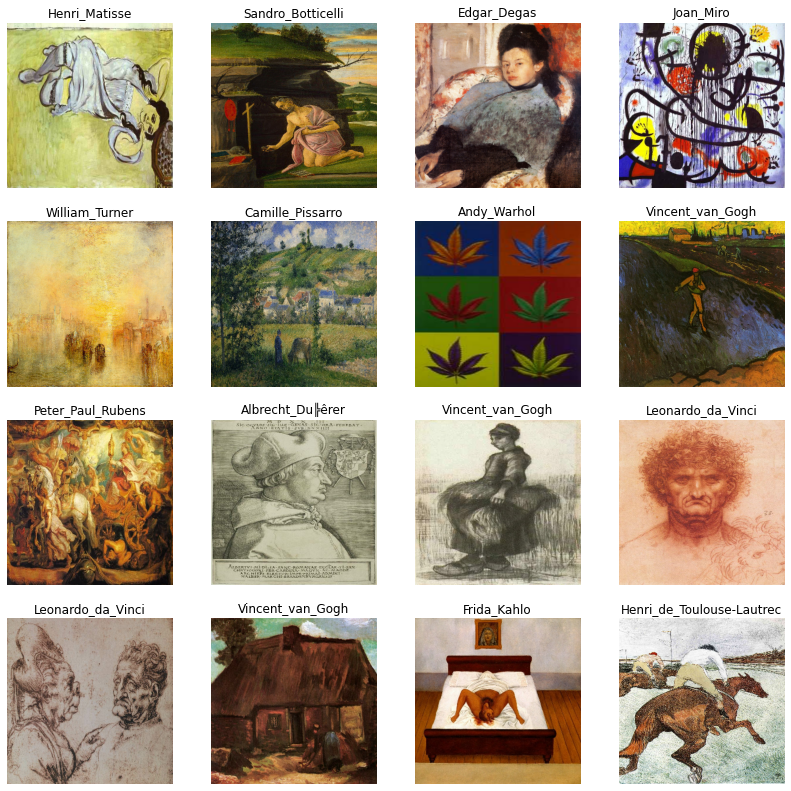

In [6]:
plt.figure(figsize=(14, 14))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 300, 300, 3)
(32,)


In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

# Data augmentation

In [10]:


data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.25),
    layers.experimental.preprocessing.RandomZoom(0.2), 
    layers.experimental.preprocessing.RandomTranslation(0.3,0.2), 
    layers.experimental.preprocessing.RandomContrast(0.2)
  ]
)

# Visualise data augmentation

Just make some plots of the results of the daa augmentation based on a random painting.

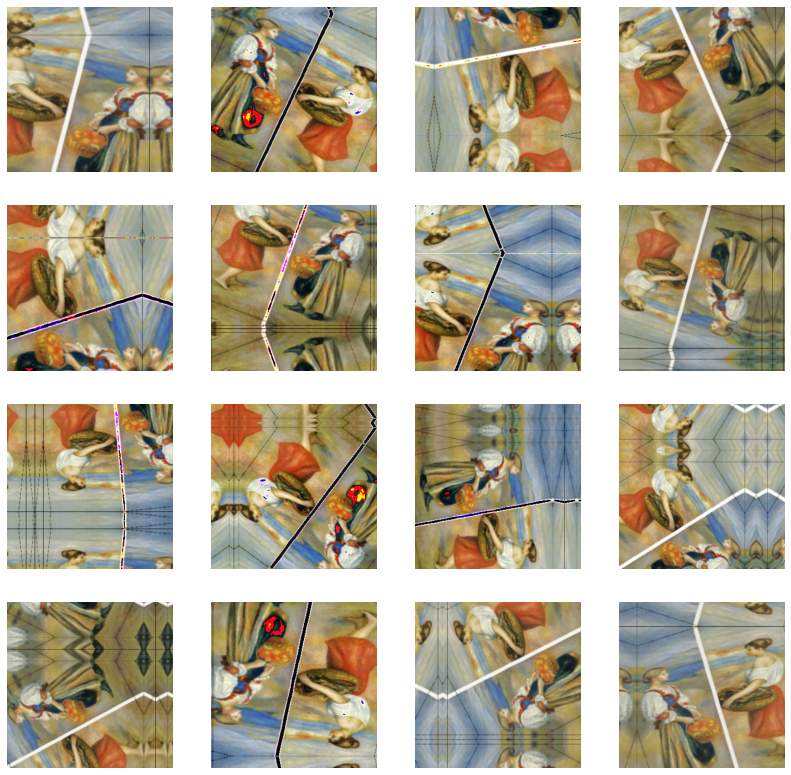

In [11]:
plt.figure(figsize=(14, 14))
for images, _ in train_ds.take(1):
  for i in range(16):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# Model

The model is a 2D convolutional neural network from scratch. Here one could probably still spend a little bit of time to improve the final results especially acuracy. One could think of using a more complex architecture or something predefined (e.g. ResNet, GoogLeNet, etc) and then attaching something in the end. 

In [12]:

CONV = 3

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, CONV, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, CONV, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, CONV, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])



As optimiser, I tried a couple of them, but RMSprop seemed to make the best job in terms of accuracy in the end. The choice for loss and metric seems kind of natural for this type of problem.

In [13]:
#define model ingredients 
opti = tf.keras.optimizers.RMSprop(momentum=0.1) 
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) 
metr = ['accuracy']

#compile model 
model.compile(optimizer = opti, 
              loss = loss, 
              metrics = metr)

In [14]:

history = model.fit(
  train_ds,
  validation_data = val_ds,
  epochs          = EPOCHS
)

Epoch 1/20
220/220 [==============================] - 37s 168ms/step - loss: 3.5704 - accuracy: 0.1329 - val_loss: 3.2315 - val_accuracy: 0.1517
Epoch 2/20
220/220 [==============================] - 10s 46ms/step - loss: 3.1350 - accuracy: 0.1758 - val_loss: 3.0409 - val_accuracy: 0.1967
Epoch 3/20
220/220 [==============================] - 10s 46ms/step - loss: 2.9931 - accuracy: 0.2145 - val_loss: 3.1675 - val_accuracy: 0.1933
Epoch 4/20
220/220 [==============================] - 10s 44ms/step - loss: 2.9219 - accuracy: 0.2194 - val_loss: 2.9248 - val_accuracy: 0.2201
Epoch 5/20
220/220 [==============================] - 10s 44ms/step - loss: 2.8488 - accuracy: 0.2326 - val_loss: 2.8356 - val_accuracy: 0.2594
Epoch 6/20
220/220 [==============================] - 10s 45ms/step - loss: 2.7745 - accuracy: 0.2506 - val_loss: 2.8295 - val_accuracy: 0.2577
Epoch 7/20
220/220 [==============================] - 10s 44ms/step - loss: 2.7207 - accuracy: 0.2642 - val_loss: 2.6773 - val_accuracy

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 300, 300, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 300, 300, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 300, 300, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)       


# Check loss and accuracy

To check for the accuracy but also of course to check on overfitting, the relevant quantities are plotted vs the number epochs.

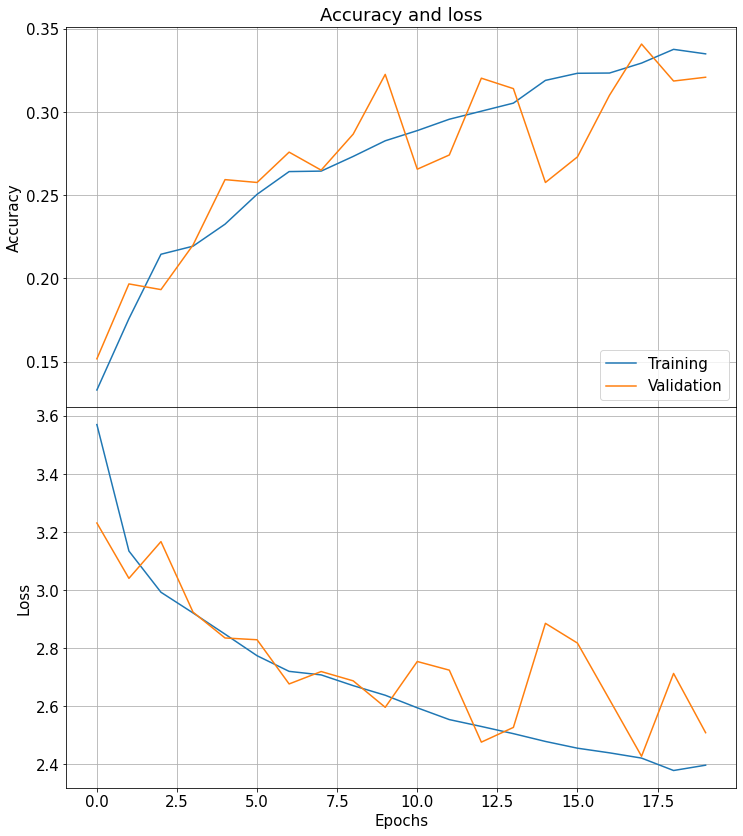

In [16]:
# get the values
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']


# show the results
epochs_range = range(EPOCHS)


plt.rcParams.update({'font.size': 15})

fig = plt.figure(figsize=(12, 14))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1]) 

ax0 = plt.subplot(gs[0])
plt.plot(epochs_range, acc, label='Training')
plt.plot(epochs_range, val_acc, label='Validation')
plt.legend(loc='lower right')
plt.title('Accuracy and loss')
plt.ylabel("Accuracy")
plt.grid(True)

ax1 = plt.subplot(gs[1], sharex = ax0)
plt.plot(epochs_range, loss, label='Training')
plt.plot(epochs_range, val_loss, label='Validation')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.grid(True)

plt.subplots_adjust(hspace=.0)
plt.show()

# Conclusion

This is a simple version of a convolutional Neural Net. Results are not that awesome, but somewhat solid considering created from scratch. Overfitting seems to be on the smaller level, so this should be okay. Using pretrained models like ResNet50 could improve the performance, will probably try this later at some point. Any further ideas, suggestions on how to increase the accuracy are of course more than welcome.